In [11]:
import numpy as np
import nltk
import pandas as pd
import collections
from absl import logging
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import os
import re
import seaborn as sns

In [12]:
from google.colab import drive
drive.mount("/content/drive/")
df = pd.read_csv("/content/drive/My Drive/NLP summer Internship/Cleanned_Complaints.csv")
df=df[df["Label"]!="Other financial service"]
df=df.dropna()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [13]:
# Load pretrained model - google universal sentence encoder
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" 
model = hub.load(module_url)
def embed(input):
  return model(input)

In [14]:
# Prepare four vendor datasets and one Well's Fargo set
df_wells=df[df["Company"]=="WELLS FARGO & COMPANY"]
credit_unions=["TRANSUNION INTERMEDIATE HOLDINGS, INC."]
banks=["CITIBANK, N.A.","BANK OF AMERICA, NATIONAL ASSOCIATION","JPMORGAN CHASE & CO.","U.S. BANCORP"]
mortgages=["Ocwen Financial Corporation","NATIONSTAR MORTGAGE","Ditech Financial LLC","SELECT PORTFOLIO SERVICING, INC.",
           "Specialized Loan Servicing Holdings LLC","SYNCHRONY FINANCIAL"]
balanced=["Santander Consumer USA Holdings Inc.","Ocwen Financial Corporation","BANK OF AMERICA, NATIONAL ASSOCIATION",
          "JPMORGAN CHASE & CO.","U.S. BANCORP","PNC Bank N.A.","UNITED SERVICES AUTOMOBILE ASSOCIATION","SUNTRUST BANKS, INC."]
df_cu=df[df["Company"].isin(credit_unions)]
df_banks=df[df["Company"].isin(banks)]
df_mortgages=df[df["Company"].isin(mortgages)]
df_balanced=df[df["Company"].isin(balanced)]

In [15]:
# Check number of documents in each dataset
cu_complaint=df_cu["Complaint_reduced"]
banks_complaint=df_banks["Complaint_reduced"]
mortgages_complaint=df_mortgages["Complaint_reduced"]
balanced_complaint=df_balanced["Complaint_reduced"]
wells_complaint=df_wells["Complaint_reduced"]
print(cu_complaint.shape,banks_complaint.shape,mortgages_complaint.shape,balanced_complaint.shape,wells_complaint.shape)

(55056,) (58302,) (29905,) (57125,) (17613,)


#### Part 1 Embedding

In [16]:
# Coding block to calculate pairwise similarity matrix
# This will take 10 minutes to embed and require around 15G memory
print("now embedding wells dataset")
# Embedding wells dataset
wells_embed=np.array(embed(wells_complaint))

print("now embedding cu dataset")
# Embedding cu dataset
cu_embed1=embed(cu_complaint[0:15000])
cu_embed2=embed(cu_complaint[15000:30000])
cu_embed3=embed(cu_complaint[30000:45000])
cu_embed4=embed(cu_complaint[45000:])
cu_embed=np.concatenate((cu_embed1,cu_embed2,cu_embed3,cu_embed4),axis=0)
del(cu_embed1)
del(cu_embed2)
del(cu_embed3)
del(cu_embed4)
#pairwise similarity
cu_wells_matrix=np.dot(wells_embed,tf.transpose(cu_embed))
#delete embedding and keep similarity matrix to save memory
del(cu_embed)

print("now embedding mortgages dataset")
# Embedding mortgages dataset
mortgages_embed1=embed(mortgages_complaint[0:15000])
mortgages_embed2=embed(mortgages_complaint[15000:])
mortgages_embed=np.concatenate((mortgages_embed1,mortgages_embed2),axis=0)
del(mortgages_embed1)
del(mortgages_embed2)
#pairwise similarity
mortgages_wells_matrix=np.dot(wells_embed,tf.transpose(mortgages_embed))
#delete embedding and keep similarity matrix to save memory
del(mortgages_embed)

print("now embedding banks dataset")
# Embedding banks dataset
banks_embed1=embed(banks_complaint[0:15000])
banks_embed2=embed(banks_complaint[15000:30000])
banks_embed3=embed(banks_complaint[30000:45000])
banks_embed4=embed(banks_complaint[45000:])
banks_embed=np.concatenate((banks_embed1,banks_embed2,banks_embed3,banks_embed4),axis=0)
del(banks_embed1)
del(banks_embed2)
del(banks_embed3)
del(banks_embed4)
banks_wells_matrix=np.dot(wells_embed,tf.transpose(banks_embed))
del(banks_embed)

print("now embedding balanced dataset")
# Embedding banks dataset
balanced_embed1=embed(balanced_complaint[0:15000])
balanced_embed2=embed(balanced_complaint[15000:30000])
balanced_embed3=embed(balanced_complaint[30000:45000])
balanced_embed4=embed(balanced_complaint[45000:])
balanced_embed=np.concatenate((balanced_embed1,balanced_embed2,balanced_embed3,balanced_embed4),axis=0)
del(balanced_embed1)
del(balanced_embed2)
del(balanced_embed3)
del(balanced_embed4)
balanced_wells_matrix=np.dot(wells_embed,tf.transpose(balanced_embed))
del(balanced_embed)
# Check pairwise similarity matrix shapes
print(cu_wells_matrix.shape,mortgages_wells_matrix.shape,banks_wells_matrix.shape,balanced_wells_matrix.shape)

now embedding wells dataset
now embedding cu dataset
now embedding mortgages dataset
now embedding banks dataset
now embedding balanced dataset
(17613, 55056) (17613, 29905) (17613, 58302) (17613, 57125)


#### Part 2 Approach

2.1 Similarity score with top N closeset sentence from vendor dataset (Adopted)

In [17]:
import math
n_similarity=5
# Compute pairwise cosine similarity and find largest n scores' average
cu_wells_top_similarity=np.sum(np.partition(cu_wells_matrix, -n_similarity)[:,-n_similarity:],axis=1)/n_similarity
mortgages_wells_top_similarity=np.sum(np.partition(mortgages_wells_matrix, -n_similarity)[:,-n_similarity:],axis=1)/n_similarity
banks_wells_top_similarity=np.sum(np.partition(banks_wells_matrix, -n_similarity)[:,-n_similarity:],axis=1)/n_similarity
balanced_wells_top_similarity=np.sum(np.partition(balanced_wells_matrix, -n_similarity)[:,-n_similarity:],axis=1)/n_similarity
# Check shape, the shape should be (wells_fargo.shape[0],)
print(cu_wells_top_similarity.shape,mortgages_wells_top_similarity.shape,banks_wells_top_similarity.shape,balanced_wells_top_similarity.shape)

(17613,) (17613,) (17613,) (17613,)


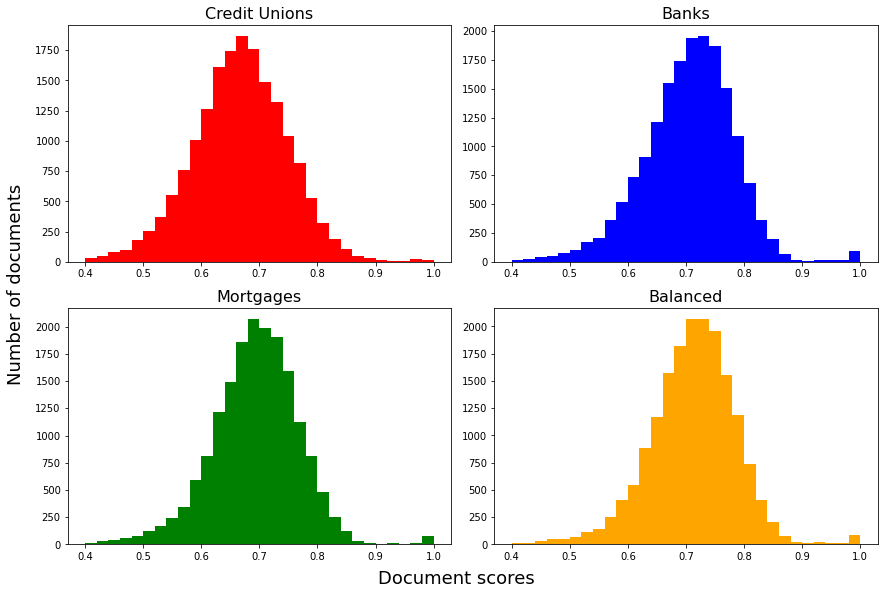

In [18]:
# Plot result distribution
fig, ax = plt.subplots(2, 2,figsize=(12, 8))

ax[0,0].set_title("Credit Unions",fontsize=16)
ax[0,1].set_title("Banks",fontsize=16)
ax[1,0].set_title("Mortgages",fontsize=16)
ax[1,1].set_title("Balanced",fontsize=16)

ax[0,0].hist(cu_wells_top_similarity,bins=30,range=(0.4,1),color="red")
ax[0,1].hist(banks_wells_top_similarity,bins=30,range=(0.4,1),color="blue")
ax[1,0].hist(mortgages_wells_top_similarity,bins=30,range=(0.4,1),color="green")
ax[1,1].hist(balanced_wells_top_similarity,bins=30,range=(0.4,1),color="orange")

fig.text(0.5, -0.02, 'Document scores', ha='center',size=18)
fig.text(-0.02, 0.5, 'Number of documents', va='center', rotation='vertical',size=18)

fig.tight_layout()
plt.show()

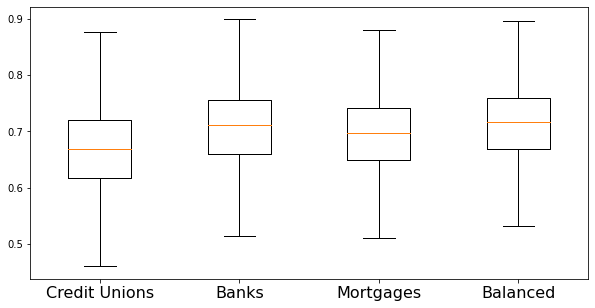

In [20]:
plt.figure(figsize=(10,5))
box_plot = [cu_wells_top_similarity, banks_wells_top_similarity, mortgages_wells_top_similarity, balanced_wells_top_similarity]
plt.boxplot(box_plot,showfliers=False)
plt.xticks(np.arange(1,5),("Credit Unions","Banks","Mortgages","Balanced"),size=16)
plt.show()

In [21]:
(np.mean(cu_wells_top_similarity)+np.mean(banks_wells_top_similarity)+np.mean(mortgages_wells_top_similarity)+np.mean(balanced_wells_top_similarity))/4

0.6943040490150452

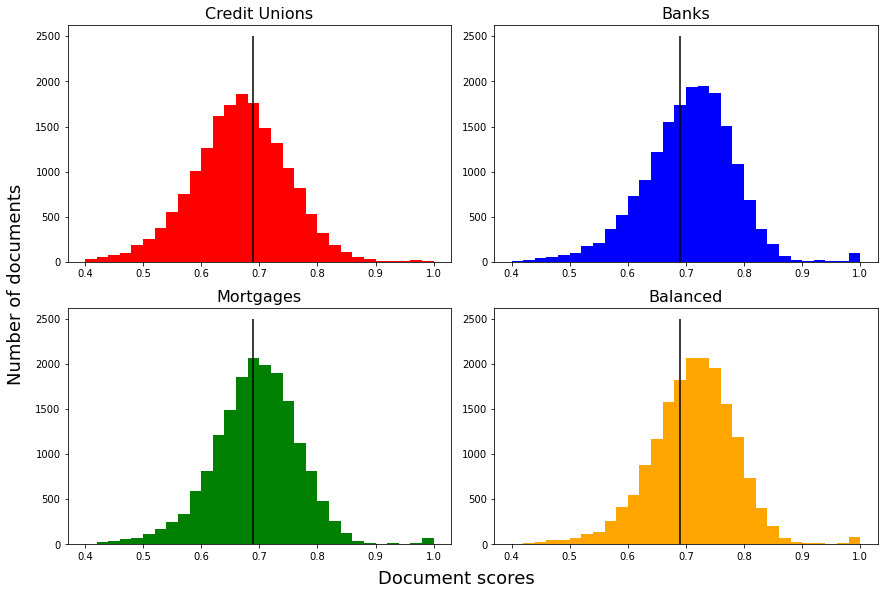

In [22]:
Threshold2=0.69
# Plot result distribution
fig, ax = plt.subplots(2, 2,figsize=(12, 8))

ax[0,0].set_title("Credit Unions",fontsize=16)
ax[0,1].set_title("Banks",fontsize=16)
ax[1,0].set_title("Mortgages",fontsize=16)
ax[1,1].set_title("Balanced",fontsize=16)

ax[0,0].hist(cu_wells_top_similarity,bins=30,range=(0.4,1),color="red")
ax[0,1].hist(banks_wells_top_similarity,bins=30,range=(0.4,1),color="blue")
ax[1,0].hist(mortgages_wells_top_similarity,bins=30,range=(0.4,1),color="green")
ax[1,1].hist(balanced_wells_top_similarity,bins=30,range=(0.4,1),color="orange")
ax[0,0].vlines(x=Threshold2,ymin=0,ymax=2500)
ax[0,1].vlines(x=Threshold2,ymin=0,ymax=2500)
ax[1,0].vlines(x=Threshold2,ymin=0,ymax=2500)
ax[1,1].vlines(x=Threshold2,ymin=0,ymax=2500)

fig.text(0.5, -0.02, 'Document scores', ha='center',size=18)
fig.text(-0.02, 0.5, 'Number of documents', va='center', rotation='vertical',size=18)

fig.tight_layout()
plt.show()

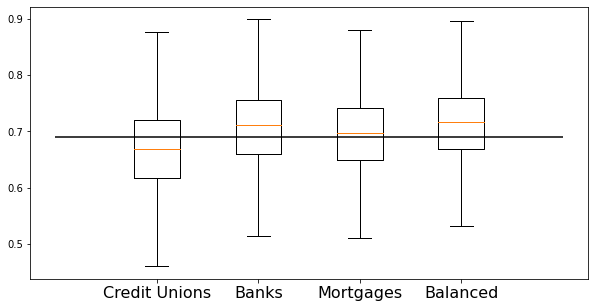

In [23]:
plt.figure(figsize=(10,5))
box_plot = [cu_wells_top_similarity, banks_wells_top_similarity, mortgages_wells_top_similarity, balanced_wells_top_similarity]
plt.boxplot(box_plot,showfliers=False)
plt.hlines(y=0.69,xmin=0,xmax=5)
plt.xticks(np.arange(1,5),("Credit Unions","Banks","Mortgages","Balanced"),size=16)
plt.show()

In [24]:
print(np.sum(cu_wells_top_similarity>0.69)/cu_wells_top_similarity.shape[0])
print(np.sum(banks_wells_top_similarity>0.69)/banks_wells_top_similarity.shape[0])
print(np.sum(mortgages_wells_top_similarity>0.69)/mortgages_wells_top_similarity.shape[0])
print(np.sum(balanced_wells_top_similarity>0.69)/balanced_wells_top_similarity.shape[0])

0.38664622721853176
0.6110827229887015
0.5389768920683586
0.6448078124112872


#### Approach 2.2 Use define closes meaning sentence as cosine similarity >= some threshold, find number of close meaning sentence as document score (dropped due to heuristic to set such threshold and interpretability to graph)


In [25]:
# Nearest neighbours threshold
similarity_threshold=0.95
# Count pairs for each document in Wells fargo set which passed the threshold
cu_wells_threshold_count=np.sum((cu_wells_matrix>=similarity_threshold),axis=1)
mortgages_wells_threshold_count=np.sum((mortgages_wells_matrix>=similarity_threshold),axis=1)
banks_wells_threshold_count=np.sum((banks_wells_matrix>=similarity_threshold),axis=1)
balanced_wells_threshold_count=np.sum((balanced_wells_matrix>=similarity_threshold),axis=1)

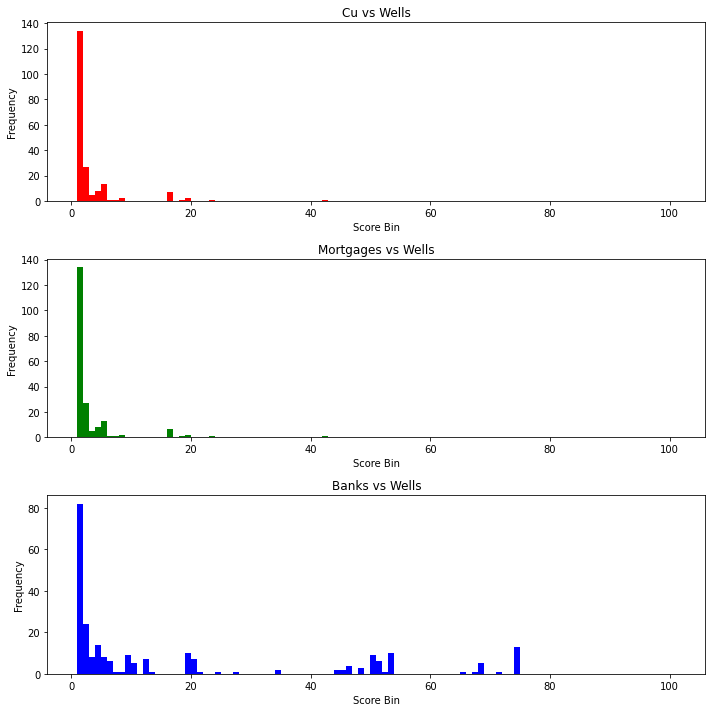

In [26]:
# Plot
fig, ax = plt.subplots(nrows=3, ncols=1,figsize=(10,10))
ax[0].set_title("Cu vs Wells")
ax[0].set_xlabel("Score Bin")
ax[0].set_ylabel("Frequency")
ax[0].hist(cu_wells_threshold_count,alpha=1,bins=100,range=(1,101),color="red")

ax[1].set_title("Mortgages vs Wells")
ax[1].set_xlabel("Score Bin")
ax[1].set_ylabel("Frequency")
ax[1].hist(cu_wells_threshold_count,alpha=1,bins=100,range=(1,101),color="green")

ax[2].set_title("Banks vs Wells")
ax[2].set_xlabel("Score Bin")
ax[2].set_ylabel("Frequency")
ax[2].hist(banks_wells_threshold_count,alpha=1,bins=100,range=(1,101),color="blue")

plt.tight_layout()
plt.show()

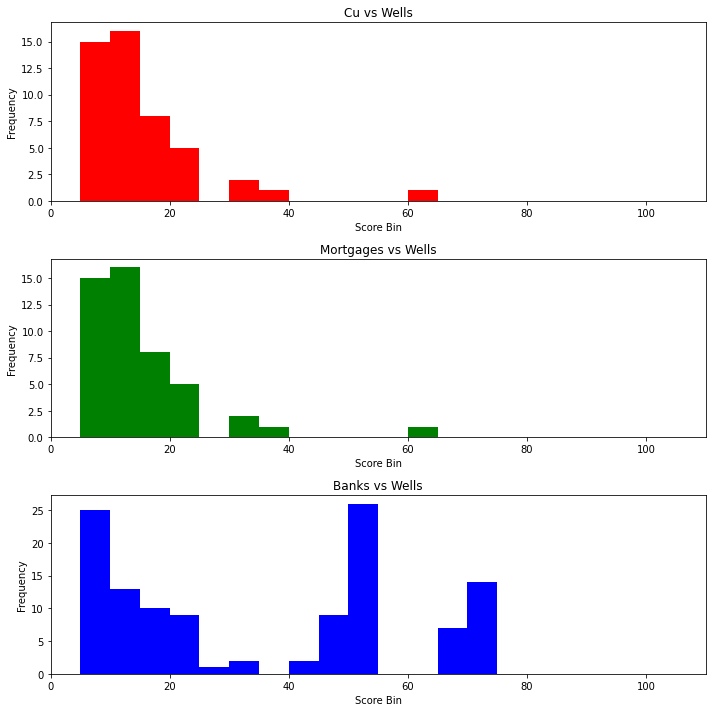

In [ ]:
# Plot use different range and bin size
fig, ax = plt.subplots(nrows=3, ncols=1,figsize=(10,10))
ax[0].set_title("Cu vs Wells")
ax[0].set_xlabel("Score Bin")
ax[0].set_ylabel("Frequency")
ax[0].hist(cu_wells_threshold_count,alpha=1,bins=20,range=(5,105),color="red")

ax[1].set_title("Mortgages vs Wells")
ax[1].set_xlabel("Score Bin")
ax[1].set_ylabel("Frequency")
ax[1].hist(cu_wells_threshold_count,alpha=1,bins=20,range=(5,105),color="green")

ax[2].set_title("Banks vs Wells")
ax[2].set_xlabel("Score Bin")
ax[2].set_ylabel("Frequency")
ax[2].hist(banks_wells_threshold_count,alpha=1,bins=20,range=(5,105),color="blue")

plt.tight_layout()
plt.show()